In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from autogluon.tabular import TabularDataset, TabularPredictor
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Initial data exploration

In [35]:
data = pd.read_csv('/Users/pawellasica/PycharmProjects/asi-project/data/01_raw/diamonds.csv',index_col=0)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53940 entries, 1 to 53940
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


In [37]:
data.clarity.unique()

array(['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF'],
      dtype=object)

In [38]:
data.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [39]:
data.dropna(inplace=True)

# EDA

In [40]:
def eda_num(col: pd.Series):
  if col.dtype == 'float':
    fig, ax = plt.subplots(1,2,figsize=(14,8))
    sns.kdeplot(data=col, ax=ax[0])
    sns.boxplot(y=col, ax=ax[1])
  else:
    fig, ax = plt.subplots(1,2,figsize=(14,8))
    sns.histplot(data=col, ax=ax[0])
    sns.boxplot(y=col, ax=ax[1])
  plt.show()

## Carat


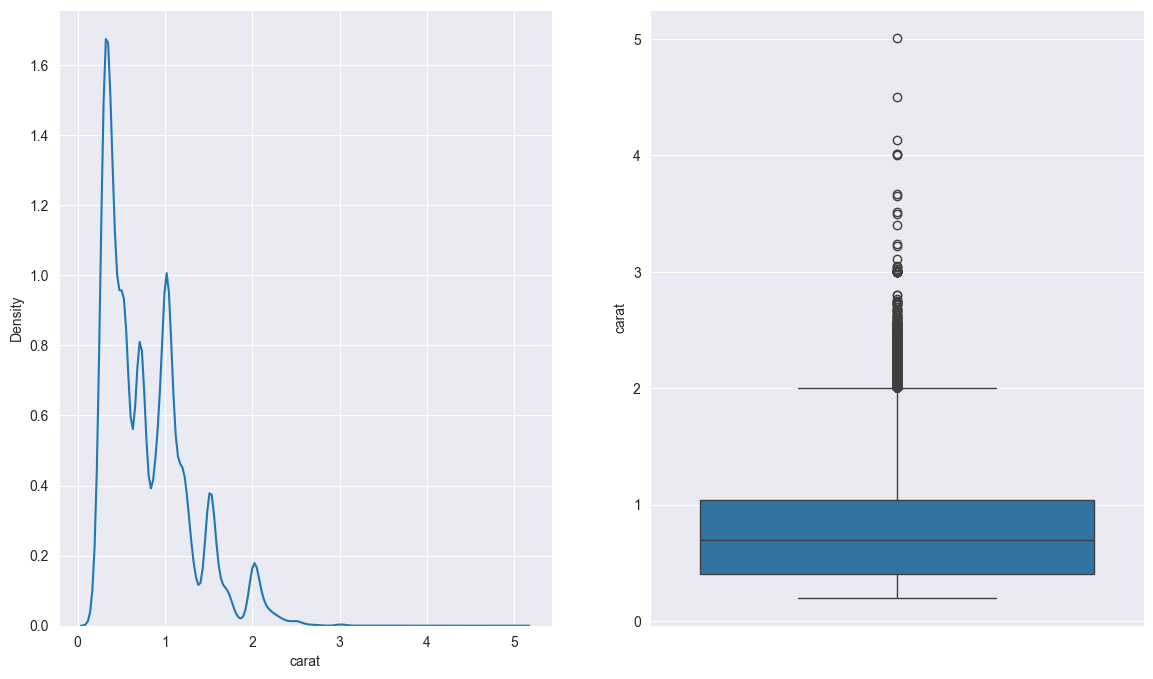

In [41]:
eda_num(data['carat'])

## Clarity

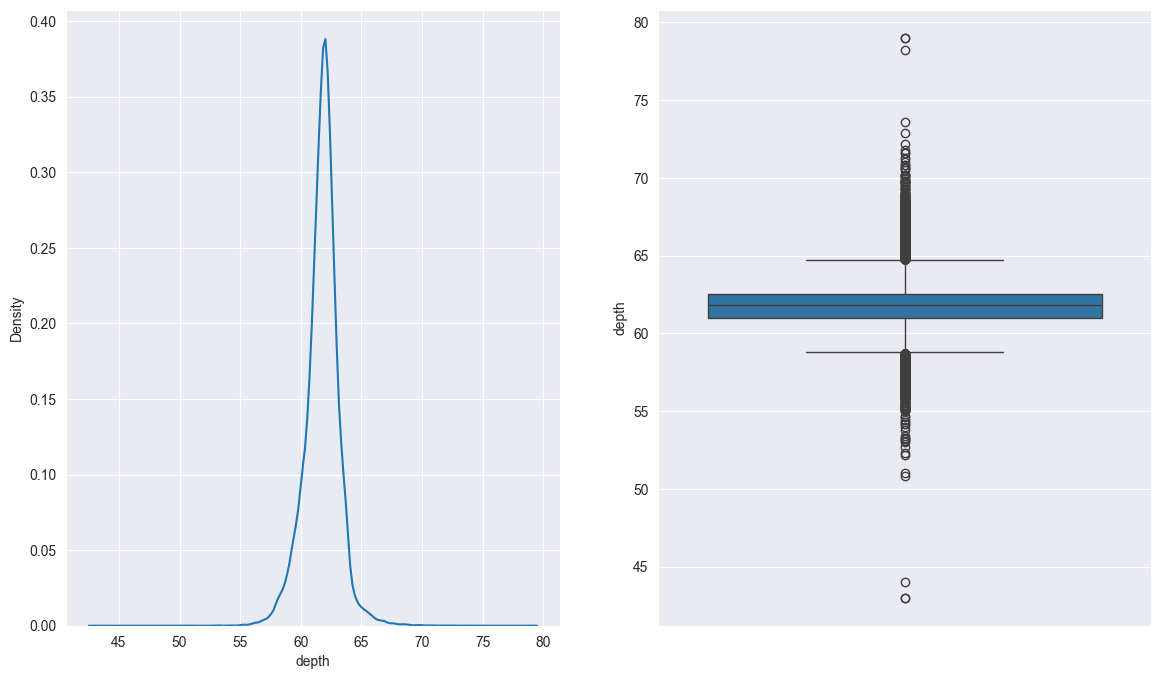

In [42]:
eda_num(data['depth'])

## Table

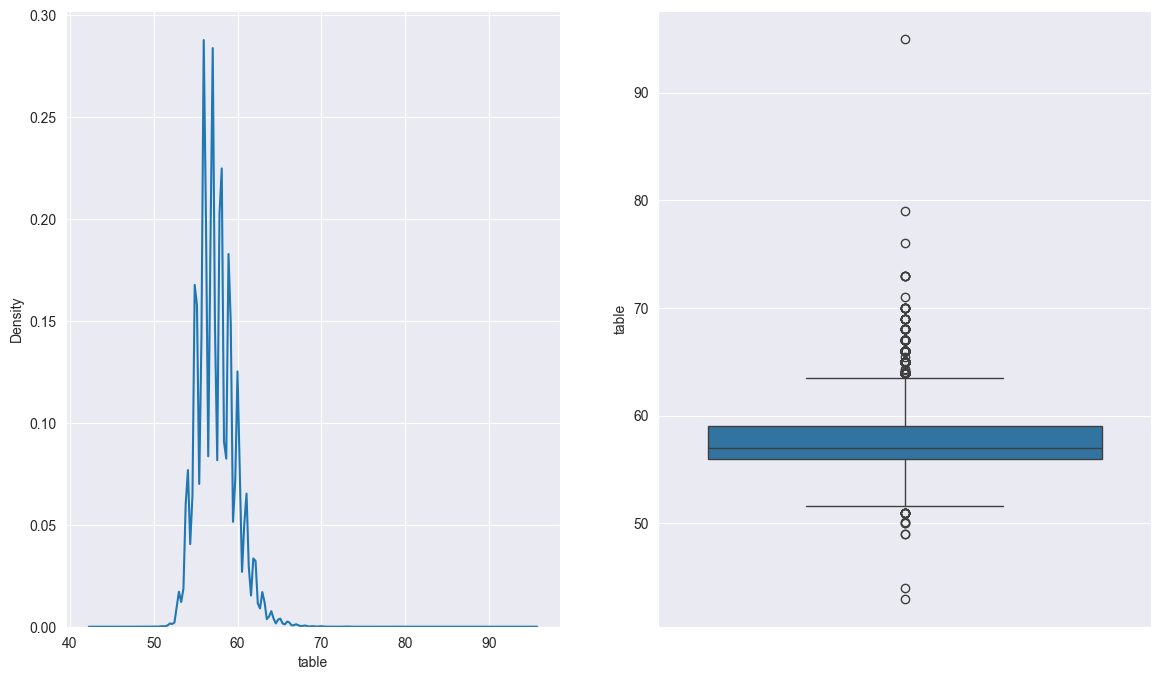

In [43]:
eda_num(data['table'])

## Price

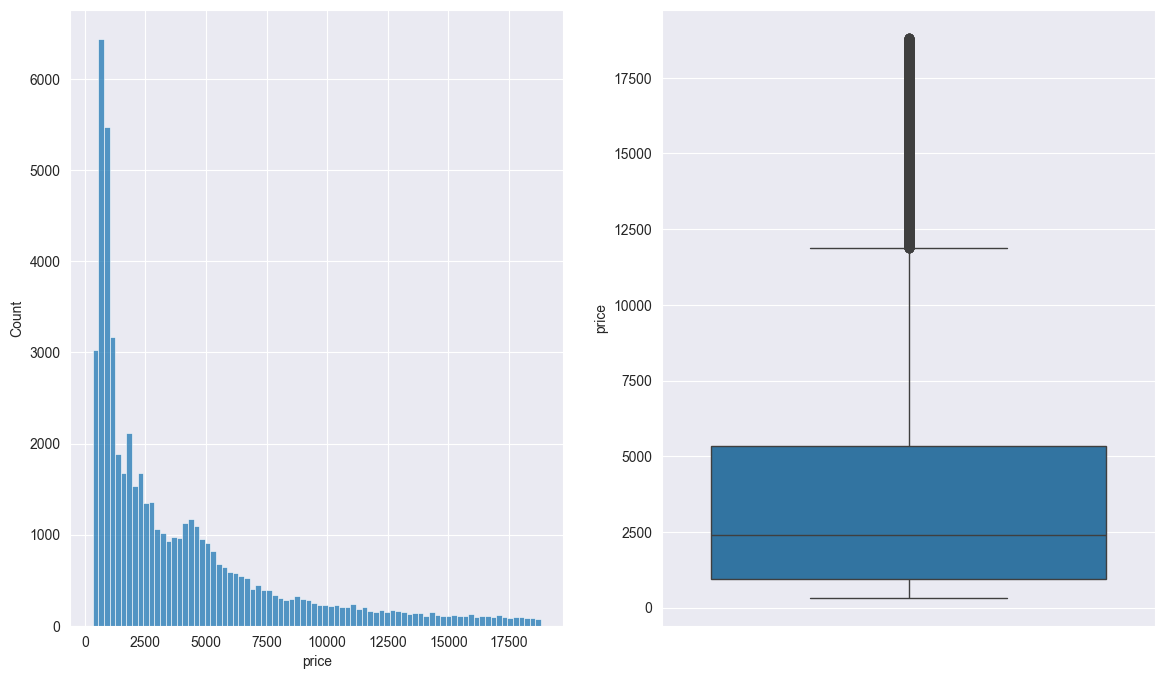

In [44]:
eda_num(data['price'])

## x

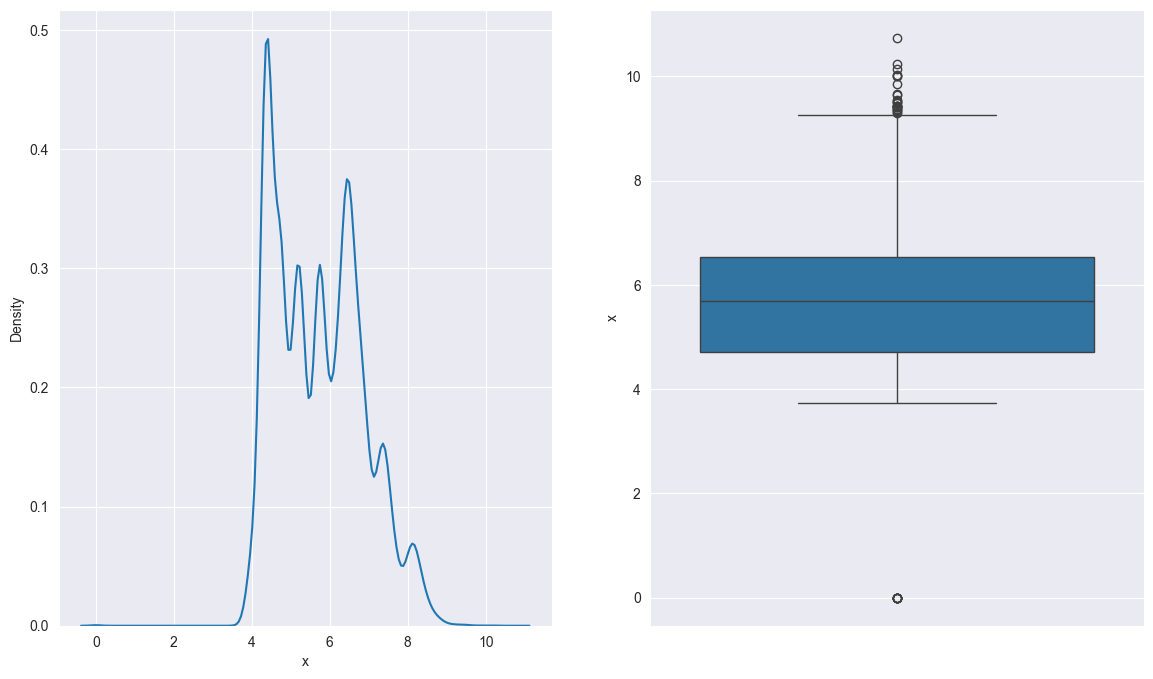

In [45]:
eda_num(data['x'])

## y

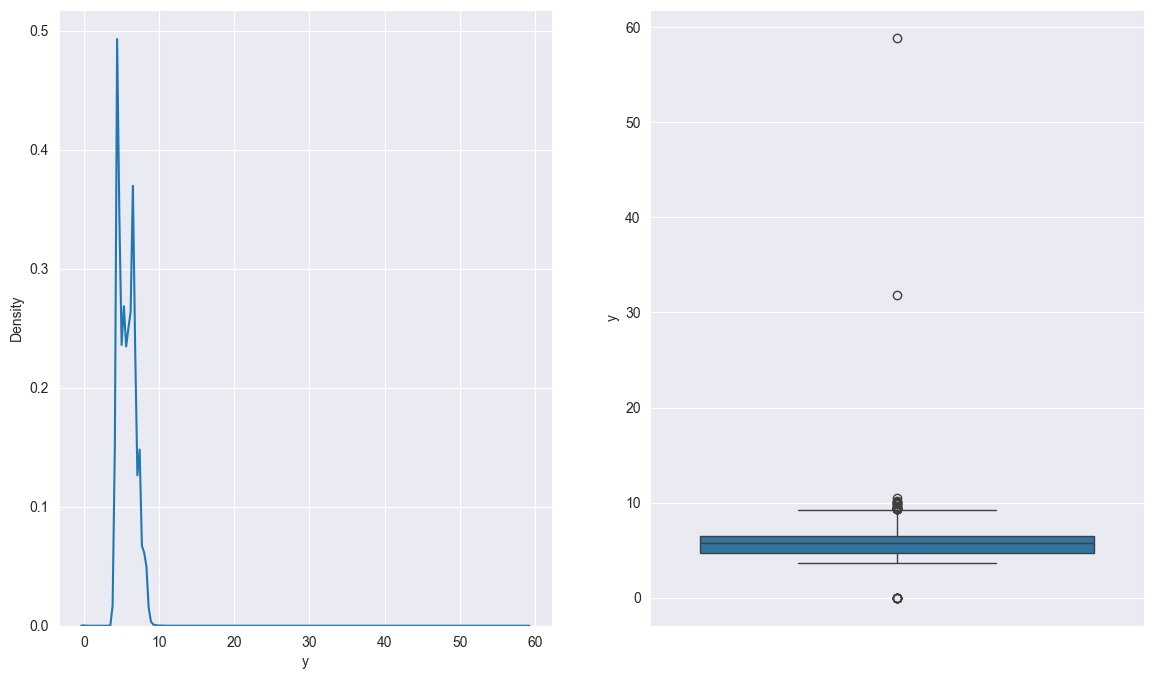

In [46]:
eda_num(data['y'])

## z

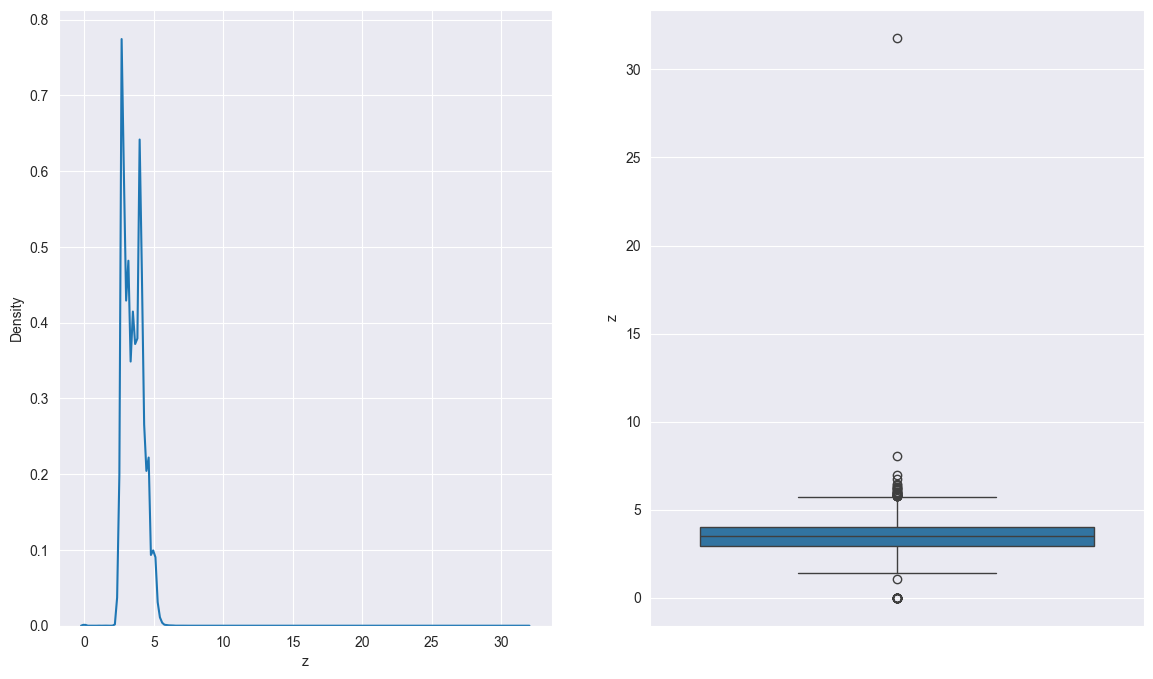

In [47]:
eda_num(data['z'])

# Remove outliers

In [48]:
def remove_outlier(data, col_name):
  q1 = data[col_name].quantile(0.25)
  q3 = data[col_name].quantile(0.75)

  iqr = q3-q1
  cond = (data[col_name] <= q3 + 1.5*iqr) & (data[col_name] >= q1 -1.5*iqr)

  data = data[cond]
  return data

In [49]:
for col in ['x','y','z','depth','carat']:
  data = remove_outlier(data,col)

# Remove target

In [50]:
price = data.price
data = data.drop(['price'], axis=1)

# Ordinal encoder

In [51]:
cat_col_names = data.select_dtypes(include=['object']).columns.tolist()
cat_col_names

['cut', 'color', 'clarity']

In [52]:
num_col_names =  data.select_dtypes(exclude=['object']).columns.tolist()
num_col_names

['carat', 'depth', 'table', 'x', 'y', 'z']

In [53]:
data = data.reset_index(drop=True)

In [54]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder() 
data[cat_col_names] = encoder.fit_transform(data[cat_col_names])

In [55]:
data

,carat,cut,color,clarity,depth,table,x,y,z
0,0.23,2.0,1.0,3.0,61.5,55.0,3.95,3.98,2.43
1,0.21,3.0,1.0,2.0,59.8,61.0,3.89,3.84,2.31
2,0.29,3.0,5.0,5.0,62.4,58.0,4.20,4.23,2.63
3,0.31,1.0,6.0,3.0,63.3,58.0,4.34,4.35,2.75
4,0.24,4.0,6.0,7.0,62.8,57.0,3.94,3.96,2.48
...,...,...,...,...,...,...,...,...,...
50053,0.72,2.0,0.0,2.0,60.8,57.0,5.75,5.76,3.50
50054,0.72,1.0,0.0,2.0,63.1,55.0,5.69,5.75,3.61
50055,0.70,4.0,0.0,2.0,62.8,60.0,5.66,5.68,3.56
50056,0.86,3.0,4.0,3.0,61.0,58.0,6.15,6.12,3.74


carat: np.float32\
depth: np.float32\
table: np.float32\
x: np.float32\
y: np.float32\
z: np.float32\
color: ['E', 'I', 'J', 'H', 'F', 'G', 'D']
cut: ['Ideal', 'Premium', 'Good', 'Very Good', 'Fair']
clarity: ['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF']

# Split data

In [56]:
X_train, X_test, y_train, y_test = train_test_split(data, price,test_size=0.2, random_state=1)

# Standardize numerical values

In [70]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns).reset_index(drop=True)

In [71]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns).reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


# Modeling

In [63]:
model = XGBRegressor()
model.fit(X_train_scaled_df, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [64]:
metrics = pd.DataFrame(index=['Train', 'Test'], columns=['MSE', 'R2_score', 'MAE'])

train_pred = model.predict(X_train_scaled_df)
test_pred = model.predict(X_test_scaled_df)


metrics.loc['Train', 'MSE'] = mean_squared_error(y_train, train_pred)
metrics.loc['Train', 'R2_score'] = r2_score(y_train, train_pred)
metrics.loc['Train', 'MAE'] = mean_absolute_error(y_train, train_pred)

metrics.loc['Test', 'MSE'] = mean_squared_error(y_test, test_pred)
metrics.loc['Test', 'R2_score'] = r2_score(y_test, test_pred)
metrics.loc['Test', 'MAE'] = mean_absolute_error(y_test, test_pred)

In [72]:
train_data = TabularDataset(pd.concat([X_train_scaled_df,y_train],axis=1))
test_data = TabularDataset(pd.concat([X_test_scaled_df,y_test],axis=1))


In [73]:
train_data = TabularDataset(train_data)
test_data = TabularDataset(test_data)

In [83]:

predictor = TabularPredictor(label="price", ).fit(train_data)

No path specified. Models will be saved in: "AutogluonModels/ag-20231220_203620"
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets.
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='best_quality'   : Maximize accuracy. Default time_limit=3600.
	presets='high_quality'   : Strong accuracy with fast inference speed. Default time_limit=3600.
	presets='good_quality'   : Good accuracy with very fast inference speed. Default time_limit=3600.
	presets='medium_quality' : Fast training time, ideal for initial prototyping.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20231220_203620"
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.13
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 23.1.0: Mon Oct  9 21:28:31 PDT

In [86]:
pred = predictor.predict(test_data)

In [87]:
metrics.loc['GluonTest', 'MSE'] = mean_squared_error(y_test, pred)
metrics.loc['GluonTest', 'R2_score'] = r2_score(y_test, pred)
metrics.loc['GluonTest', 'MAE'] = mean_absolute_error(y_test, pred)
mean_squared_error

<function sklearn.metrics._regression.mean_squared_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', squared=True)>

In [88]:
metrics

,MSE,R2_score,MAE
Train,111795.348751,0.991199,194.079726
Test,229482.319104,0.981918,247.414456
GluonTest,212548.3293,0.983252,234.592014


/var/folders/0g/9jtz54gd44qf0_8mtlv7wpjh0000gn/T/ipykernel_17662/4001993839.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  metrics[['MSE','R2_score','MAE']].plot(kind='bar', ax=ax,subplots=True, rot=0)


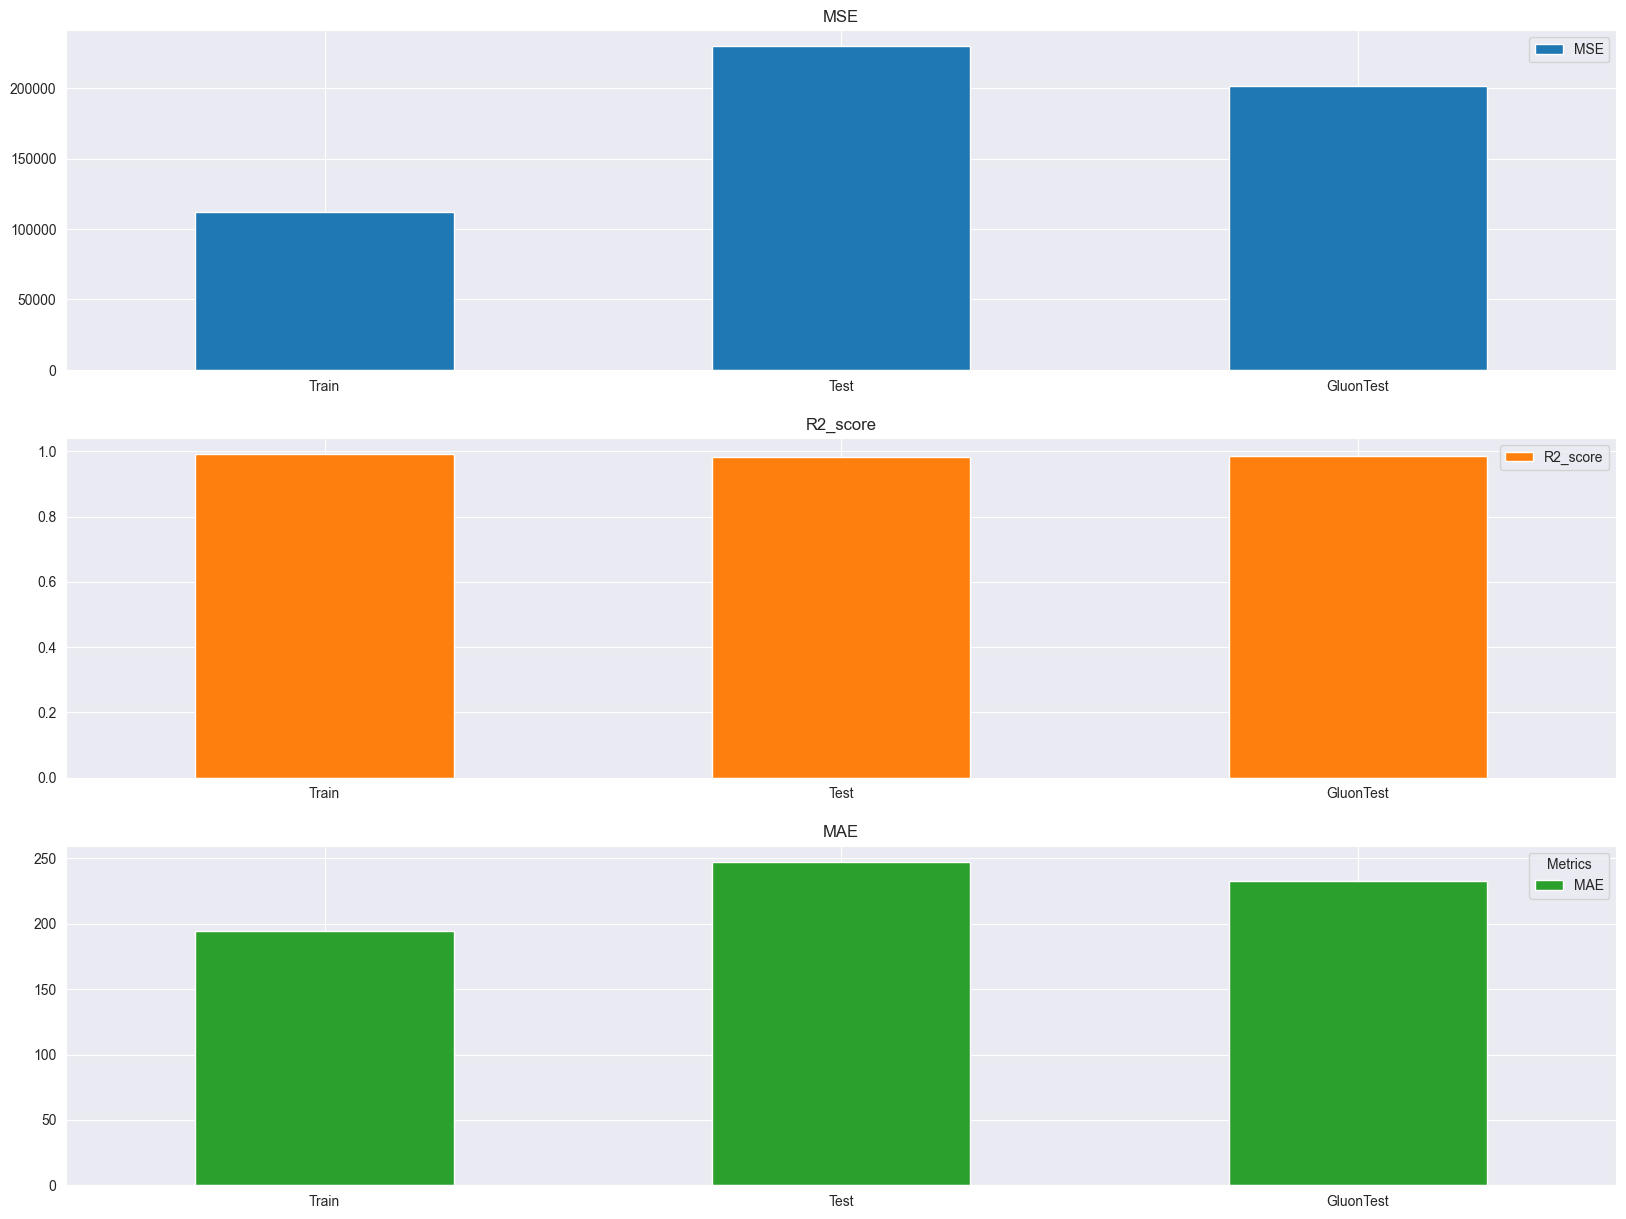

In [77]:
fig, ax = plt.subplots(figsize=(20, 15))
metrics[['MSE','R2_score','MAE']].plot(kind='bar', ax=ax,subplots=True, rot=0)
ax.set_ylabel('Values')
ax.set_title('Comparison of Train and Test Metrics')

plt.legend(title='Metrics')
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV
params_grid = {
    'n_estimators': [380,680,200],
    'max_depth': [8,9],
    'learning_rate': [0.05],
    'subsample': [0.95],
    'colsample_bytree': [0.9,0.91]
}

# Create the XGBoost regressor model
model = XGBRegressor()

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(model, params_grid, scoring='neg_mean_absolute_error', cv=5)
grid_search.fit(X_train_scaled, y_train)
best_params = grid_search.best_params_
model = XGBRegressor(**best_params)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
R2 = r2_score(y_test, y_pred)
print("MSE:", MSE)
print("R2:", R2)
print("MAE:", MAE)